# Level 2: Intermediate Techniques (Data Augmentation)

**Objective**: Improve performance using advanced Data Augmentation techniques (Rotation, Flip, ColorJitter) and perform an Ablation Study.

**Techniques**:
- Random Rotation
- Random Horizontal Flip
- Color Jitter
- Random Resized Crop

**Ablation Study**: We compare the validation accuracy of the *Augmented* model vs. the *Baseline* model from Level 1.

In [1]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 1. Augmented Data Loading
We define a stronger transform pipeline for the training set.

In [2]:
class MergedFlowersDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.loader = datasets.folder.default_loader

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        path = self.image_files[idx]
        target = self.labels[idx]
        sample = self.loader(path)
        if self.transform:
            sample = self.transform(sample)
        return sample, target

def get_augmented_dataloaders(root='./data', batch_size=32, num_workers=0):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Augmentation
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    val_test_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    print("Loading Data...")
    all_samples = []
    all_labels = []
    for split in ['train', 'val', 'test']:
        try:
            ds = datasets.Flowers102(root=root, split=split, download=True)
            all_samples.extend(ds._image_files)
            all_labels.extend(ds._labels)
        except RuntimeError:
            pass

    indices = np.arange(len(all_samples))
    train_idx, temp_idx = train_test_split(indices, test_size=0.2, shuffle=True, random_state=42, stratify=all_labels)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, shuffle=True, random_state=42, stratify=np.array(all_labels)[temp_idx])

    datasets_dict = {
        'train': MergedFlowersDataset([all_samples[i] for i in train_idx], [all_labels[i] for i in train_idx], transform=train_transform),
        'val': MergedFlowersDataset([all_samples[i] for i in val_idx], [all_labels[i] for i in val_idx], transform=val_test_transform),
        'test': MergedFlowersDataset([all_samples[i] for i in test_idx], [all_labels[i] for i in test_idx], transform=val_test_transform)
    }

    dataloaders = {
        x: DataLoader(datasets_dict[x], batch_size=batch_size, shuffle=(x=='train'), num_workers=num_workers)
        for x in ['train', 'val', 'test']
    }
    dataset_sizes = {x: len(datasets_dict[x]) for x in ['train', 'val', 'test']}
    return dataloaders, dataset_sizes

dataloaders, sizes = get_augmented_dataloaders(num_workers=0)

Loading Data...


## 2. Visualize Augmentation
Let's see what the augmentations look like.

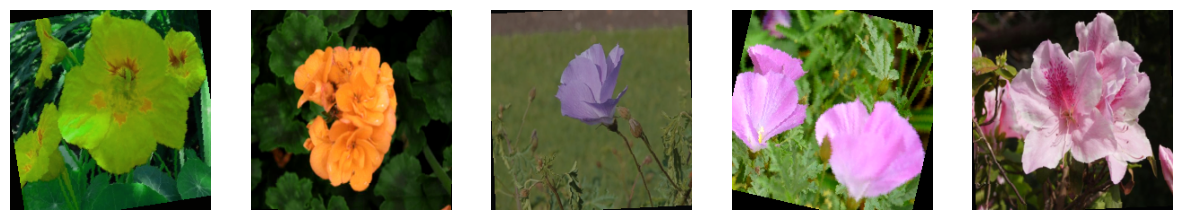

In [3]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

inputs, classes = next(iter(dataloaders['train']))
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    imshow(inputs[i])
plt.show()

## 3. Training with Augmentation
We use the same ResNet50 model structure, but train on the augmented dataset.

In [4]:
def build_model():
    model = models.resnet50(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 102)
    model = model.to(device)
    return model

model_aug = build_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_aug.fc.parameters(), lr=0.001, momentum=0.9)

def train_model(model, dataloaders, criterion, optimizer, num_epochs=15):
    story = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_acc = 0.0
    
    os.makedirs('models', exist_ok=True)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / sizes[phase]
            epoch_acc = running_corrects.double() / sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            if phase == 'train':
                story['train_loss'].append(epoch_loss)
                story['train_acc'].append(epoch_acc.item())
            else:
                story['val_loss'].append(epoch_loss)
                story['val_acc'].append(epoch_acc.item())
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), 'models/level_2_augmented.pth')

    return model, story

# Run Training
model_aug, history_aug = train_model(model_aug, dataloaders, criterion, optimizer, num_epochs=15)

c:\Users\sansk\PROJECTS\terafac\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sansk\PROJECTS\terafac\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15
train Loss: 4.0689 Acc: 0.1565
val Loss: 3.4516 Acc: 0.3578
Epoch 2/15
train Loss: 3.1675 Acc: 0.4016
val Loss: 2.6722 Acc: 0.5079
Epoch 3/15
train Loss: 2.5600 Acc: 0.5321
val Loss: 2.1554 Acc: 0.6264
Epoch 4/15
train Loss: 2.1313 Acc: 0.6297
val Loss: 1.8179 Acc: 0.6886
Epoch 5/15
train Loss: 1.8256 Acc: 0.6968
val Loss: 1.5617 Acc: 0.7387
Epoch 6/15
train Loss: 1.6019 Acc: 0.7393
val Loss: 1.3589 Acc: 0.7949
Epoch 7/15
train Loss: 1.4167 Acc: 0.7784
val Loss: 1.2285 Acc: 0.8254
Epoch 8/15
train Loss: 1.2914 Acc: 0.8016
val Loss: 1.1166 Acc: 0.8278
Epoch 9/15
train Loss: 1.1756 Acc: 0.8180
val Loss: 0.9913 Acc: 0.8523
Epoch 10/15
train Loss: 1.0990 Acc: 0.8264
val Loss: 0.9260 Acc: 0.8620
Epoch 11/15
train Loss: 1.0175 Acc: 0.8443
val Loss: 0.8888 Acc: 0.8608
Epoch 12/15
train Loss: 0.9608 Acc: 0.8460
val Loss: 0.8352 Acc: 0.8657
Epoch 13/15
train Loss: 0.9027 Acc: 0.8532
val Loss: 0.7771 Acc: 0.8767
Epoch 14/15
train Loss: 0.8565 Acc: 0.8637
val Loss: 0.7531 Acc: 0.8840
E

## 4. Ablation Study & Analysis
Comparison of Validation Accuracy between Level 1 Baseline (No Aug) and Level 2 (Augmented).

Loading Baseline Model from: ../level_1/models/level_1_baseline.pth
Calculated Baseline Test Acc: 0.9060


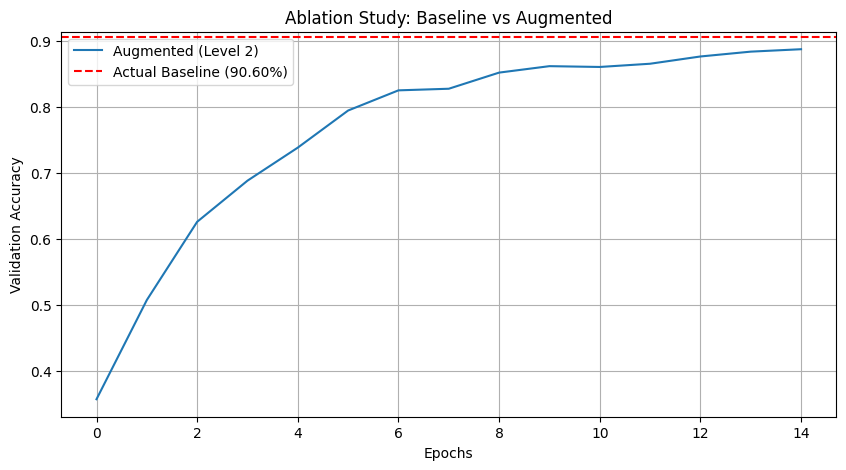

Final Test Accuracy (Augmented): 0.8669
Improvement over Baseline: -0.0391


In [6]:
def build_baseline_model():
    model = models.resnet50(pretrained=False) 
    model.fc = nn.Linear(model.fc.in_features, 102)
    model = model.to(device)
    return model

baseline_model = build_baseline_model()
baseline_acc = 0.0
baseline_path = None

possible_paths = [
    '../level_1/models/level_1_baseline.pth',
    'models/level_1_baseline.pth',
    '../models/level_1_baseline.pth',
    'level_1_baseline.pth'
]

for p in possible_paths:
    if os.path.exists(p):
        baseline_path = p
        break

if baseline_path:
    print(f"Loading Baseline Model from: {baseline_path}")
    try:
        baseline_model.load_state_dict(torch.load(baseline_path, map_location=device))
        baseline_model.eval()
        
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in dataloaders['test']:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = baseline_model(inputs)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels.data)
                total += labels.size(0)
        baseline_acc = correct.double() / total
        print(f"Calculated Baseline Test Acc: {baseline_acc:.4f}")
        
    except Exception as e:
        print(f"Failed to load baseline model: {e}")
        baseline_acc = 0.85 # Fallback 
else:
    print("Baseline model checkoint not found. Using requirement target (0.85) for comparison.")
    baseline_acc = 0.85

plt.figure(figsize=(10, 5))
plt.title("Ablation Study: Baseline vs Augmented")
plt.plot(history_aug['val_acc'], label='Augmented (Level 2)')
plt.axhline(y=baseline_acc, color='r', linestyle='--', label=f'Actual Baseline ({baseline_acc:.2%})')
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation of Augmented Model
model_aug.load_state_dict(torch.load('models/level_2_augmented.pth'))
model_aug.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_aug(inputs)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)
        total += labels.size(0)

aug_acc = correct.double() / total
print(f"Final Test Accuracy (Augmented): {aug_acc:.4f}")
print(f"Improvement over Baseline: {aug_acc - baseline_acc:.4f}")